### Problem Statements:    

The proliferation of social media enables people to express their opinions widely online. However, at the same time, this has resulted in the emergence of conflict and hate, making online environments uninviting for users. Although researchers have found that hate is a problem across multiple platforms, there is a lack of models for online hate detection.
Online hate, described as abusive language, aggression, cyberbullying, hatefulness and many others has been identified as a major threat on online social media platforms. Social media platforms are the most prominent grounds for such toxic behaviour.   
There has been a remarkable increase in the cases of cyberbullying and trolls on various social media platforms. Many celebrities and influences are facing backlashes from people and have to come across hateful and offensive comments. This can take a toll on anyone and affect them mentally leading to depression, mental illness, self-hatred and suicidal thoughts.    
Internet comments are bastions of hatred and vitriol. While online anonymity has provided a new outlet for aggression and hate speech, machine learning can be used to fight it. The problem we sought to solve was the tagging of internet comments that are aggressive towards other users. This means that insults to third parties such as celebrities will be tagged as unoffensive, but “u are an idiot” is clearly offensive.
Our goal is to build a prototype of online hate and abuse comment classifier which can used to classify hate and offensive comments so that it can be controlled and restricted from spreading hatred and cyberbullying. 


#### Let's start with importing the important libraries.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import  stopwords

# Wordcloud for visualising most used words
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords

from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

# Import tools to split data and evaluate model performance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Import ML algos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

#### Load dataset

In [2]:
traindf=pd.read_csv('train.csv')

In [3]:
traindf.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
testdf=pd.read_csv('test.csv')

In [5]:
testdf.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
testdf.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [7]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [8]:
# columns in the dataset.
for i in traindf.columns:
    print(i)

id
comment_text
malignant
highly_malignant
rude
threat
abuse
loathe


In [9]:
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


#### checking null values in the dataset.

In [10]:
traindf.isnull().sum()

id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

No null values available in the dataset

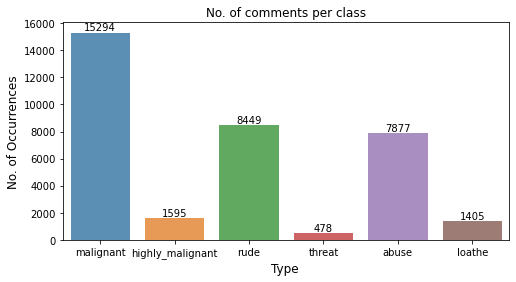

In [11]:
plt.figure(figsize=(8,4))
ax = sns.barplot(traindf.iloc[:,2:].sum().index, traindf.iloc[:,2:].sum().values, alpha=0.8)
plt.title("No. of comments per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
rects = ax.patches
labels = traindf.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

In [12]:
#create a bar graph

sum_mal=traindf['malignant'].sum()/len(traindf)*100
sum_hig=traindf['highly_malignant'].sum()/len(traindf)*100
sum_rude=traindf['rude'].sum()/len(traindf)*100
sum_thr=traindf['threat'].sum()/len(traindf)*100
sum_abu=traindf['abuse'].sum()/len(traindf)*100
sum_loa=traindf['loathe'].sum()/len(traindf)*100

In [13]:
# initiate a list of 6 values that represents the 6 x-axis values for the categoreis
ind=np.arange(6)

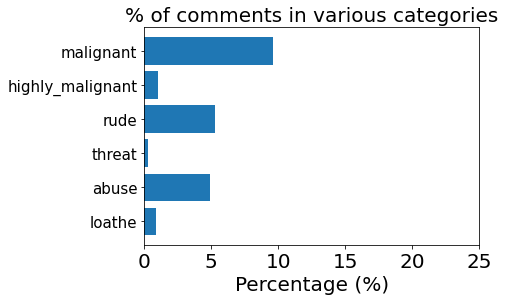

In [14]:

# Let the ind variable be the x-axis, whereas the % of toxicity for each category be the y-axis.
# Sequence of % have been sorted manually. This method cannot be done if there are large numbers of categories.
ax = plt.barh(ind, [sum_mal, sum_hig, sum_rude, sum_thr, sum_abu, sum_loa])
plt.xlabel('Percentage (%)', size=20)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.title('% of comments in various categories', size=20)
plt.yticks(ind, ('malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe' ), size=15)

# Invert the graph so that it is in descending order.
plt.gca().invert_yaxis()
plt.show()

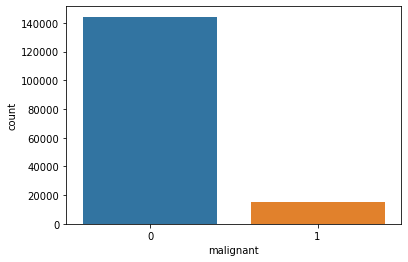

0    144277
1     15294
Name: malignant, dtype: int64


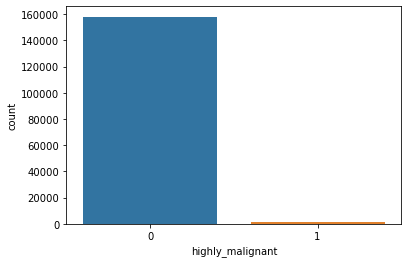

0    157976
1      1595
Name: highly_malignant, dtype: int64


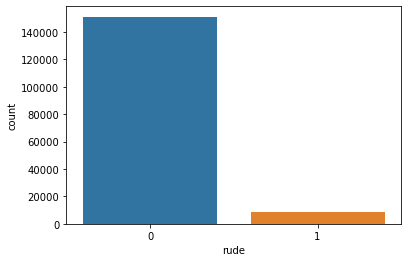

0    151122
1      8449
Name: rude, dtype: int64


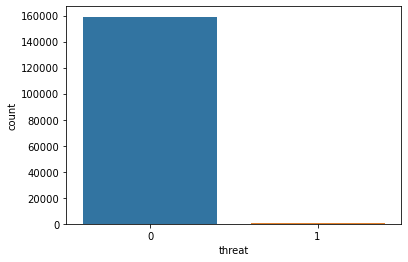

0    159093
1       478
Name: threat, dtype: int64


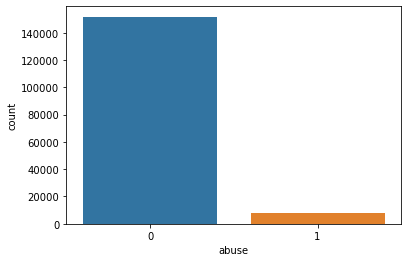

0    151694
1      7877
Name: abuse, dtype: int64


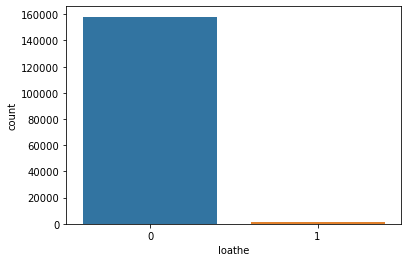

0    158166
1      1405
Name: loathe, dtype: int64


In [15]:
for columns in traindf.iloc[:,2:]:
    sns.countplot(traindf[columns])
    plt.show()
    print(traindf[columns].value_counts())

In [16]:
# remove all numbers with letters attached to them
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - convert all strings to lowercase 
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

# Apply all the lambda functions wrote previously through .map on the comments column
traindf['comment_text'] = traindf['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

In [17]:
# seperating the labels

df_data_mal=traindf.loc[:,['id','comment_text','malignant']]
df_data_hig=traindf.loc[:,['id','comment_text','highly_malignant']]
df_data_rude=traindf.loc[:,['id','comment_text','rude']]
df_data_thr=traindf.loc[:,['id','comment_text','threat']]
df_data_abu=traindf.loc[:,['id','comment_text','abuse']]
df_data_loa=traindf.loc[:,['id','comment_text','loathe']]

In [18]:

def wordcloud(df, label):
    
    # Print only rows where the toxic category label value is 1 (ie. the comment is toxic)
    subset=df[df[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="black",max_words=4000)
    wc.generate(" ".join(text))

    plt.figure(figsize=(25,25))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(random_state=244), alpha=0.98)

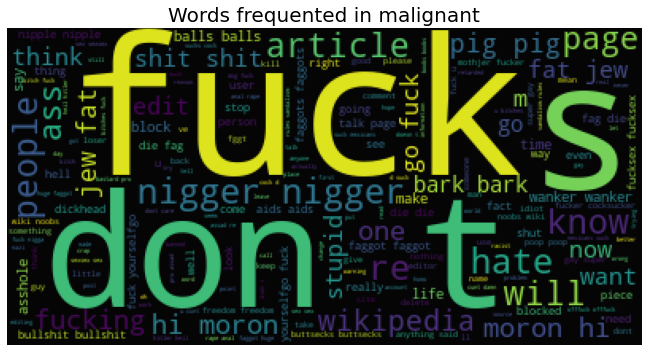

In [19]:
wordcloud(df_data_mal,'malignant')

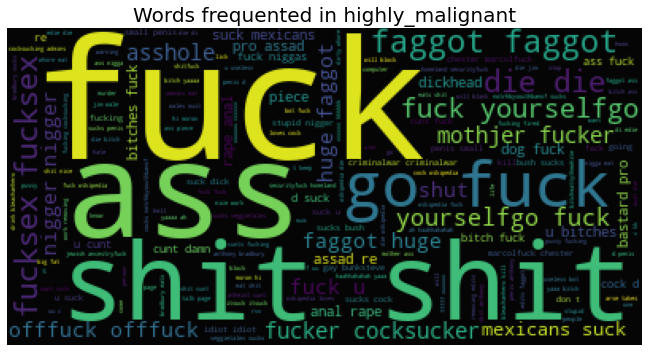

In [20]:
wordcloud(df_data_hig,'highly_malignant')

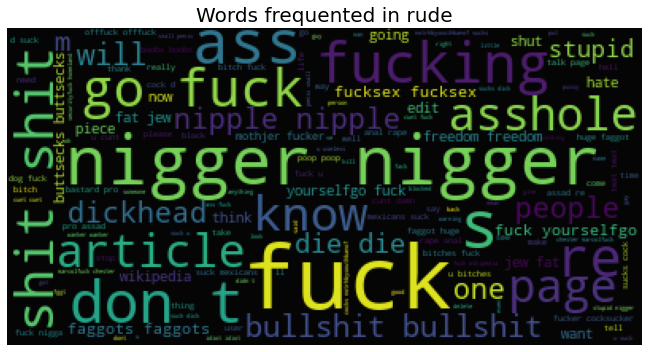

In [21]:
wordcloud(df_data_rude,'rude')

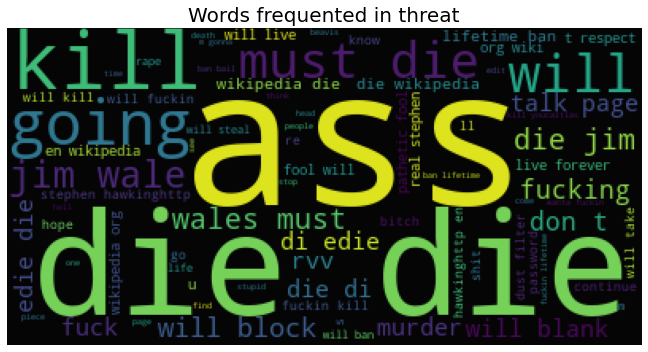

In [22]:
wordcloud(df_data_thr,'threat')

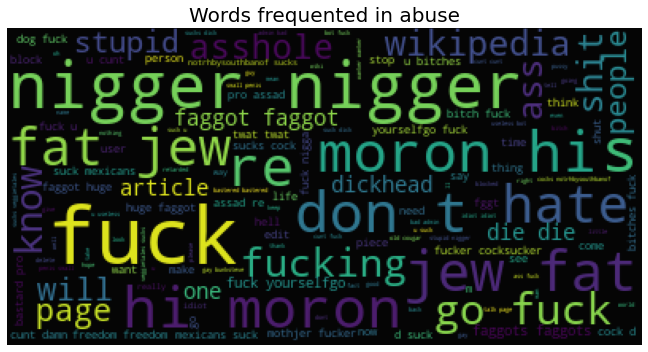

In [23]:
wordcloud(df_data_abu, 'abuse')

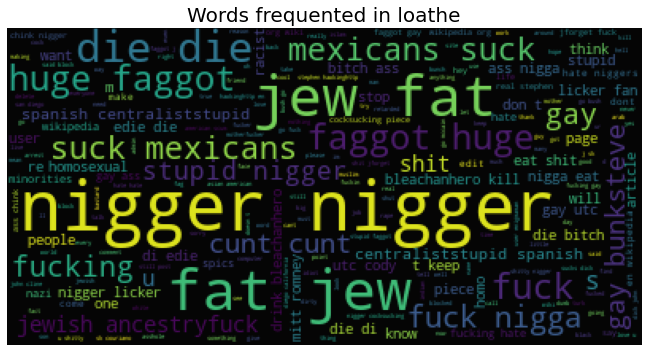

In [24]:
wordcloud(df_data_loa,'loathe')

In [25]:
# # Making the unbalanced data a balanced One
df_data_mal_1 = df_data_mal[df_data_mal['malignant'] == 1].iloc[0:5000,:]
df_data_mal_1.shape

(5000, 3)

In [26]:
df_data_mal_0 = df_data_mal[df_data_mal['malignant'] == 0].iloc[0:5000,:]
df_data_mal_0

,id,comment_text,malignant
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0
...,...,...,...
5544,0ece9249484eddb9,electronic intifada is not an activist site w...,0
5545,0ece971b58a3def7,new genre the new genre supernatural was use...,0
5547,0ecf7cde3391615b,translated as the second vatican council a ...,0
5549,0ed11396420e8531,purpose this rfc will be used to determine com...,0


In [27]:
df_data_mal_done = pd.concat([df_data_mal_1, df_data_mal_0], axis=0)
df_data_mal_done.shape

(10000, 3)

In [28]:
df_data_hig[df_data_hig['highly_malignant'] == 1].count()

id                  1595
comment_text        1595
highly_malignant    1595
dtype: int64

In [29]:
df_data_hig_1 = df_data_hig[df_data_hig['highly_malignant'] == 1].iloc[0:1595,:]
df_data_hig_0 = df_data_hig[df_data_hig['highly_malignant'] == 0].iloc[0:1595,:]
df_data_hig_done = pd.concat([df_data_hig_1, df_data_hig_0], axis=0)
df_data_hig_done.shape

(3190, 3)

In [30]:
df_data_rude[df_data_rude['rude'] == 1].count()

id              8449
comment_text    8449
rude            8449
dtype: int64

In [31]:
df_data_rude_1 = df_data_rude[df_data_rude['rude'] == 1].iloc[0:5000,:]
df_data_rude_0 = df_data_rude[df_data_rude['rude'] == 0].iloc[0:5000,:]
df_data_rude_done = pd.concat([df_data_rude_1, df_data_rude_0], axis=0)
df_data_rude_done.shape

(10000, 3)

In [32]:
df_data_thr[df_data_thr['threat'] == 1].count()

id              478
comment_text    478
threat          478
dtype: int64

In [34]:
df_data_thr_1 = df_data_thr[df_data_thr['threat'] == 1].iloc[0:478,:]

In [35]:
# We include 1912 comments that have no threat so that the data with threat (478) will represent 20% of the dataset.
df_data_thr_0 = df_data_thr[df_data_thr['threat'] == 0].iloc[0:1912,:]  
df_data_thr_done = pd.concat([df_data_thr_1, df_data_thr_0], axis=0)
df_data_thr_done.shape

(2390, 3)

In [36]:
df_data_abu[df_data_abu['abuse'] == 1].count()

id              7877
comment_text    7877
abuse           7877
dtype: int64

In [37]:
df_data_abu_1 = df_data_abu[df_data_abu['abuse'] == 1].iloc[0:5000,:]
df_data_abu_0 = df_data_abu[df_data_abu['abuse'] == 0].iloc[0:5000,:]
df_data_abu_done = pd.concat([df_data_abu_1, df_data_abu_0], axis=0)
df_data_abu_done.shape

(10000, 3)

In [38]:
df_data_loa_1 = df_data_loa[df_data_loa['loathe'] == 1].iloc[0:1405,:] # 20%
df_data_loa_0 = df_data_loa[df_data_loa['loathe'] == 0].iloc[0:5620,:] # 80%
df_data_loa_done = pd.concat([df_data_loa_1, df_data_loa_0], axis=0)
df_data_loa_done.shape

(7025, 3)

In [40]:
def cv_tf_train_test(df_done,label,vectorizer,ngram):

    ''' Train/Test split'''
    # Split the data into X and y data sets
    X = df_done.comment_text
    y = df_done[label]

    # Split our data into training and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    ''' Count Vectorizer/TF-IDF '''

    # Create a Vectorizer object and remove stopwords from the table
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')
    
    X_train_cv1 = cv1.fit_transform(X_train) # Learn the vocabulary dictionary and return term-document matrix
    X_test_cv1  = cv1.transform(X_test)      # Learn a vocabulary dictionary of all tokens in the raw documents.
    
    # Output a Dataframe of the CountVectorizer with unique words as the labels
    # test = pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names())
        
    ''' Initialize all model objects and fit the models on the training data '''
    lr = LogisticRegression()
    lr.fit(X_train_cv1, y_train)
    print('lr done')

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_cv1, y_train)

    bnb = BernoulliNB()
    bnb.fit(X_train_cv1, y_train)
    print('bnb done')
    
    mnb = MultinomialNB()
    mnb.fit(X_train_cv1, y_train)
    print('mnb done')
    
    svm_model = LinearSVC()
    svm_model.fit(X_train_cv1, y_train)

    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X_train_cv1, y_train)
    print('rdf done')
    
    # Create a list of F1 score of all models 
    f1_score_data = {'F1 Score':[f1_score(lr.predict(X_test_cv1), y_test), f1_score(knn.predict(X_test_cv1), y_test), 
                                f1_score(bnb.predict(X_test_cv1), y_test), f1_score(mnb.predict(X_test_cv1), y_test),
                                f1_score(svm_model.predict(X_test_cv1), y_test), f1_score(randomforest.predict(X_test_cv1), y_test)]} 
                          
    # Create DataFrame with the model names as column labels
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])  

    return df_f1

In [41]:
df_mal_cv = cv_tf_train_test(df_data_mal_done, 'malignant', TfidfVectorizer, (1,1))
df_mal_cv.rename(columns={'F1 Score': 'F1 Score(malignant)'}, inplace=True)

df_mal_cv

lr done
bnb done
mnb done
rdf done


,F1 Score(malignant)
Log Regression,0.860941
KNN,0.170616
BernoulliNB,0.776521
MultinomialNB,0.874958
SVM,0.876510
Random Forest,0.835621


In [42]:
df_hig_cv = cv_tf_train_test(df_data_hig_done, 'highly_malignant', TfidfVectorizer, (1,1))
df_hig_cv.rename(columns={'F1 Score': 'F1 Score(highly_malignant)'}, inplace=True)

df_hig_cv

lr done
bnb done
mnb done
rdf done


,F1 Score(highly_malignant)
Log Regression,0.927879
KNN,0.837809
BernoulliNB,0.803707
MultinomialNB,0.936170
SVM,0.926004
Random Forest,0.927660


In [43]:
df_rude_cv = cv_tf_train_test(df_data_rude_done, 'rude', TfidfVectorizer, (1,1))
df_rude_cv.rename(columns={'F1 Score': 'F1 Score(rude)'}, inplace=True)

df_rude_cv

lr done
bnb done
mnb done
rdf done


,F1 Score(rude)
Log Regression,0.908655
KNN,0.410982
BernoulliNB,0.787830
MultinomialNB,0.901399
SVM,0.921378
Random Forest,0.907370


In [44]:
df_thr_cv = cv_tf_train_test(df_data_thr_done, 'threat', TfidfVectorizer, (1,1))
df_thr_cv.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)

df_thr_cv

lr done
bnb done
mnb done
rdf done


,F1 Score(threat)
Log Regression,0.628821
KNN,0.586207
BernoulliNB,0.311828
MultinomialNB,0.504762
SVM,0.786765
Random Forest,0.800000


In [45]:

df_abu_cv = cv_tf_train_test(df_data_abu_done, 'abuse', TfidfVectorizer, (1,1))
df_abu_cv.rename(columns={'F1 Score': 'F1 Score(abuse)'}, inplace=True)

df_abu_cv

lr done
bnb done
mnb done
rdf done


,F1 Score(abuse)
Log Regression,0.896599
KNN,0.244898
BernoulliNB,0.783762
MultinomialNB,0.897411
SVM,0.902619
Random Forest,0.882616


In [46]:
df_loa_cv = cv_tf_train_test(df_data_loa_done, 'loathe', TfidfVectorizer, (1,1))
df_loa_cv.rename(columns={'F1 Score': 'F1 Score(loathe)'}, inplace=True)

df_loa_cv

lr done
bnb done
mnb done
rdf done


,F1 Score(loathe)
Log Regression,0.699029
KNN,0.197980
BernoulliNB,0.549206
MultinomialNB,0.485857
SVM,0.797516
Random Forest,0.769821


In [47]:
# Let's combine the dataframes into a master dataframe to compare F1 scores across all categories.
final_all = pd.concat([df_mal_cv, df_hig_cv, df_rude_cv, df_abu_cv, df_thr_cv, df_loa_cv], axis=1)
final_all

,F1 Score(malignant),F1 Score(highly_malignant),F1 Score(rude),F1 Score(abuse),F1 Score(threat),F1 Score(loathe)
Log Regression,0.860941,0.927879,0.908655,0.896599,0.628821,0.699029
KNN,0.170616,0.837809,0.410982,0.244898,0.586207,0.197980
BernoulliNB,0.776521,0.803707,0.787830,0.783762,0.311828,0.549206
MultinomialNB,0.874958,0.936170,0.901399,0.897411,0.504762,0.485857
SVM,0.876510,0.926004,0.921378,0.902619,0.786765,0.797516
Random Forest,0.835621,0.927660,0.907370,0.882616,0.800000,0.769821


In [48]:
final_all_trp = final_all.transpose()
final_all_trp

,Log Regression,KNN,BernoulliNB,MultinomialNB,SVM,Random Forest
F1 Score(malignant),0.860941,0.170616,0.776521,0.874958,0.876510,0.835621
F1 Score(highly_malignant),0.927879,0.837809,0.803707,0.936170,0.926004,0.927660
F1 Score(rude),0.908655,0.410982,0.787830,0.901399,0.921378,0.907370
F1 Score(abuse),0.896599,0.244898,0.783762,0.897411,0.902619,0.882616
F1 Score(threat),0.628821,0.586207,0.311828,0.504762,0.786765,0.800000
F1 Score(loathe),0.699029,0.197980,0.549206,0.485857,0.797516,0.769821


Text(0.5, 1.0, 'F1 Score of ML models (TF-IDF)')

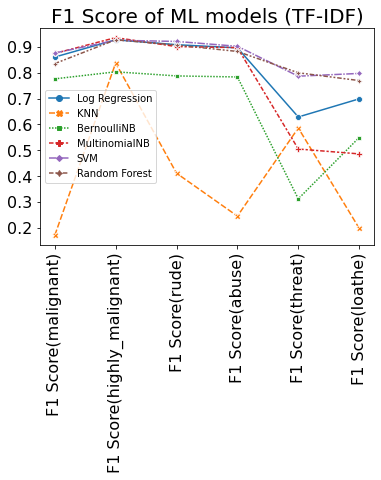

In [49]:
sns.lineplot(data=final_all_trp, markers=True)
plt.xticks(rotation='90', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best')
plt.title('F1 Score of ML models (TF-IDF)', fontsize=20)

In [50]:

# Repeat this for CountVectorizer as well


# LinearSVM and Random Forest models perform best (purple and brown lines seem to be the highest).
# 
# Test if our code actually works. Probability of the comment falling in various categories should be output.
df_data_mal_done.head()

,id,comment_text,malignant
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1
12,0005c987bdfc9d4b,hey what is it talk what is it a...,1
16,0007e25b2121310b,bye don t look come or think of comming ba...,1
42,001810bf8c45bf5f,you are gay or antisemmitian archangel whit...,1
43,00190820581d90ce,fuck your filthy mother in the ass dry,1


In [51]:
X = df_data_mal_done.comment_text
y = df_data_mal_done['malignant']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  # Convert the X data into a document term matrix dataframe
X_test_fit = tfv.transform(X_test)  # Converts the X_test comments into Vectorized format

randomforest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train our SVM model with the X training data converted into Count Vectorized format with the Y training data
randomforest.fit(X_train_fit, y_train)
randomforest.predict(X_test_fit)

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [52]:
testdf.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [53]:
# sample prediction

test_vect=tfv.transform(testdf['comment_text'])
randomforest.predict_proba(test_vect)[:,1]

array([0.92      , 0.12258283, 0.15674026, ..., 0.12492857, 0.1803355 ,
       0.7       ])

LinearSVM and Random Forest models perform best (purple and brown lines seem to be the highest)